# Single channel recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your recordings in the "data/Single_channels" folder

In [2]:
data_folder = "data/4-Single_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/4-Single_channels


['data/4-Single_channels/2024_06_11_0003.abf',
 'data/4-Single_channels/2025_06_10_0028.abf',
 'data/4-Single_channels/2025_06_10_0052 KM002 gap free 2min.abf',
 'data/4-Single_channels/2025_06_10_0032.abf',
 'data/4-Single_channels/2025_06_10_0027.abf',
 'data/4-Single_channels/2025_06_10_0025.abf',
 'data/4-Single_channels/2025_06_10_0019.abf',
 'data/4-Single_channels/2025_06_10_0057.abf']

Choose which file you want to analyze and copy/paste the file name here:

**If you get an error, make sure you copy/pasted the name correctly (e.g. with both quotation marker, without any commas)**

In [3]:
# data_file = 'data/4-Single_channels/2025_06_10_0052 KM002 gap free 2min.abf'
data_file = 'data/4-Single_channels/2025_06_10_0028.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_10_0028.abf')
data points: 1,500,000
Duration: 30.000 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage


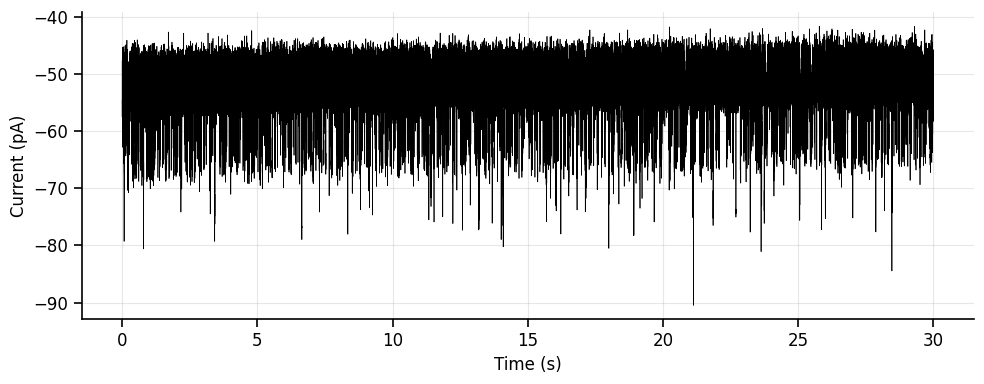

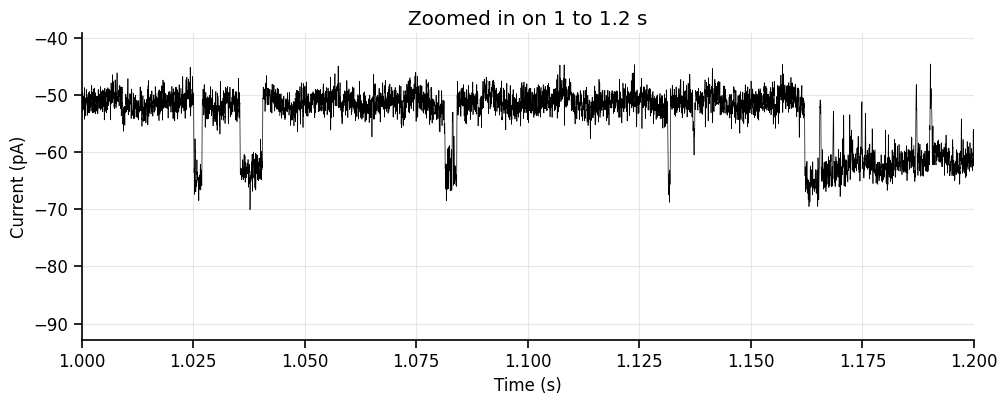

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=True)
print(traces)

time_units = 's' # specify seconds (s), or milliseconds (ms)
x_axis_range = (1,1.2) # Here you can set the rage of the x-axis to 'zoom in' on a specific part of the trace (1-2s recommended)

# ----------------------------------------------------------------------------------------------------------------
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
plt.show()
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]} to {x_axis_range[1]} {time_units}')
plt.show()

## 2. Signal processing

### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [5]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

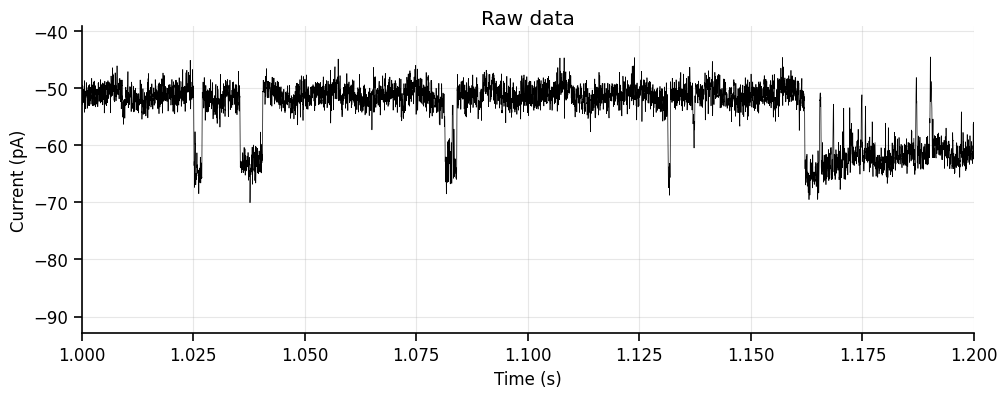

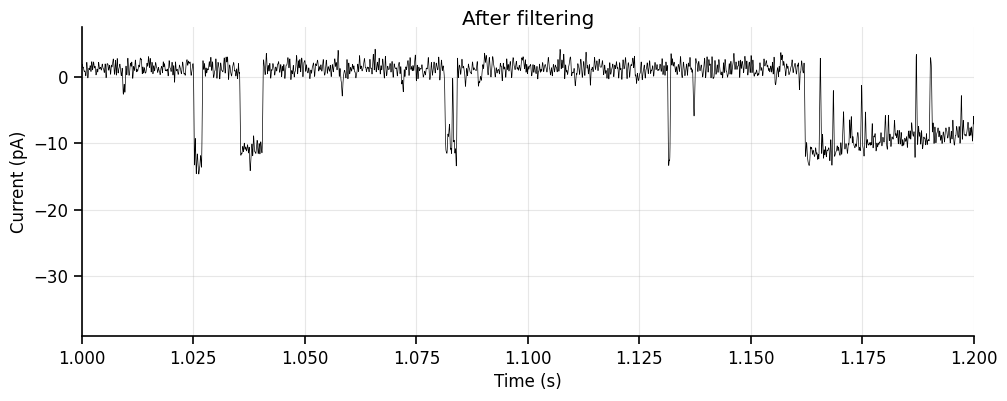

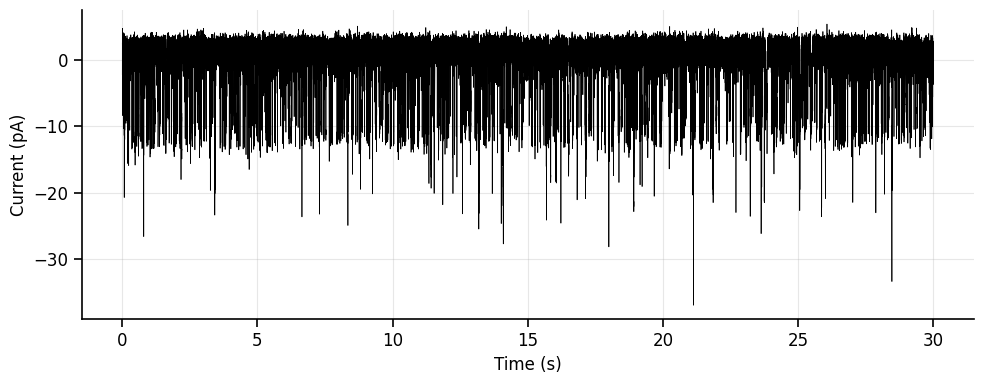

In [6]:
if apply_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

    # Step 4: Highpass filter (removes low-frequency oscillations)
    # ------------------------------------------------------------
    # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # ------------------------------------------------------------

    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False)
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False)
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [7]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [8]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

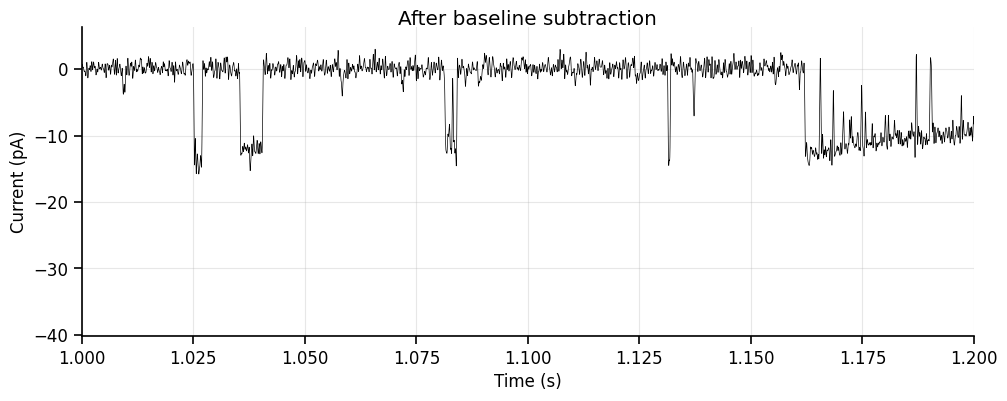

In [9]:
if subtract_baseline:
    # %matplotlib widget
    %matplotlib inline
    traces.current_data = traces.current_data - np.median(traces.current_data)
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After baseline subtraction', y=0.98)
    ax.set_xlim(x_axis_range)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### 2.3. Optional: crop trace (if the edges are not flat)

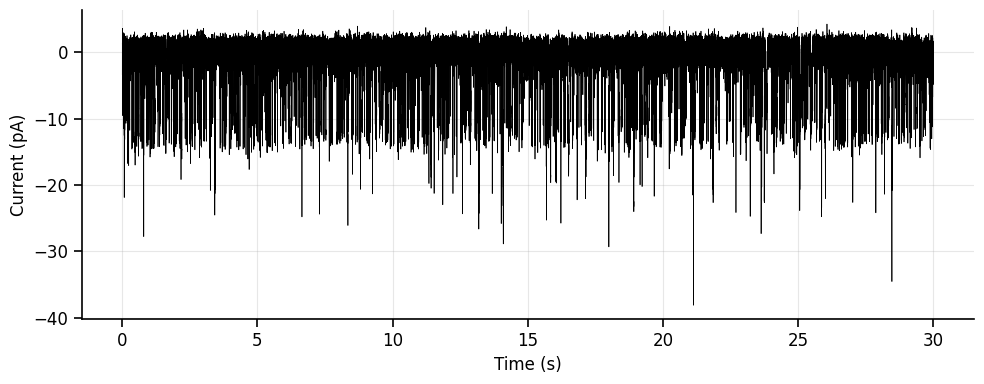

In [10]:
crop_traces = False

# The markers will define the window where we crop the traces. 'None'= No cropping.
marker_1 = None
marker_2 = None

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax = traces.plot(plot_voltage=False, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
plt.show()

In [11]:
# Apply the crop based on the markers
if crop_traces and (marker_1 is not None or marker_2 is not None):
    traces = traces.crop(timepoint=marker_1, time_units=time_units, timepoint_2=marker_2)
    ax = traces.plot(plot_voltage=False, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
    plt.show()

### 3.3. Detect the number of distinct levels (channel opening states)

In [12]:
current_direction = 'inward' # Specify 'inward' or 'outward' current

Using provided mean guesses: [0, 5, 10]
Fitted: mean=-0.173 pA, std=0.831 pA, R²=0.991
Fitted: mean=10.127 pA, std=2.011 pA, R²=0.829
Fitted: mean=2.613 pA, std=1.060 pA, R²=0.869


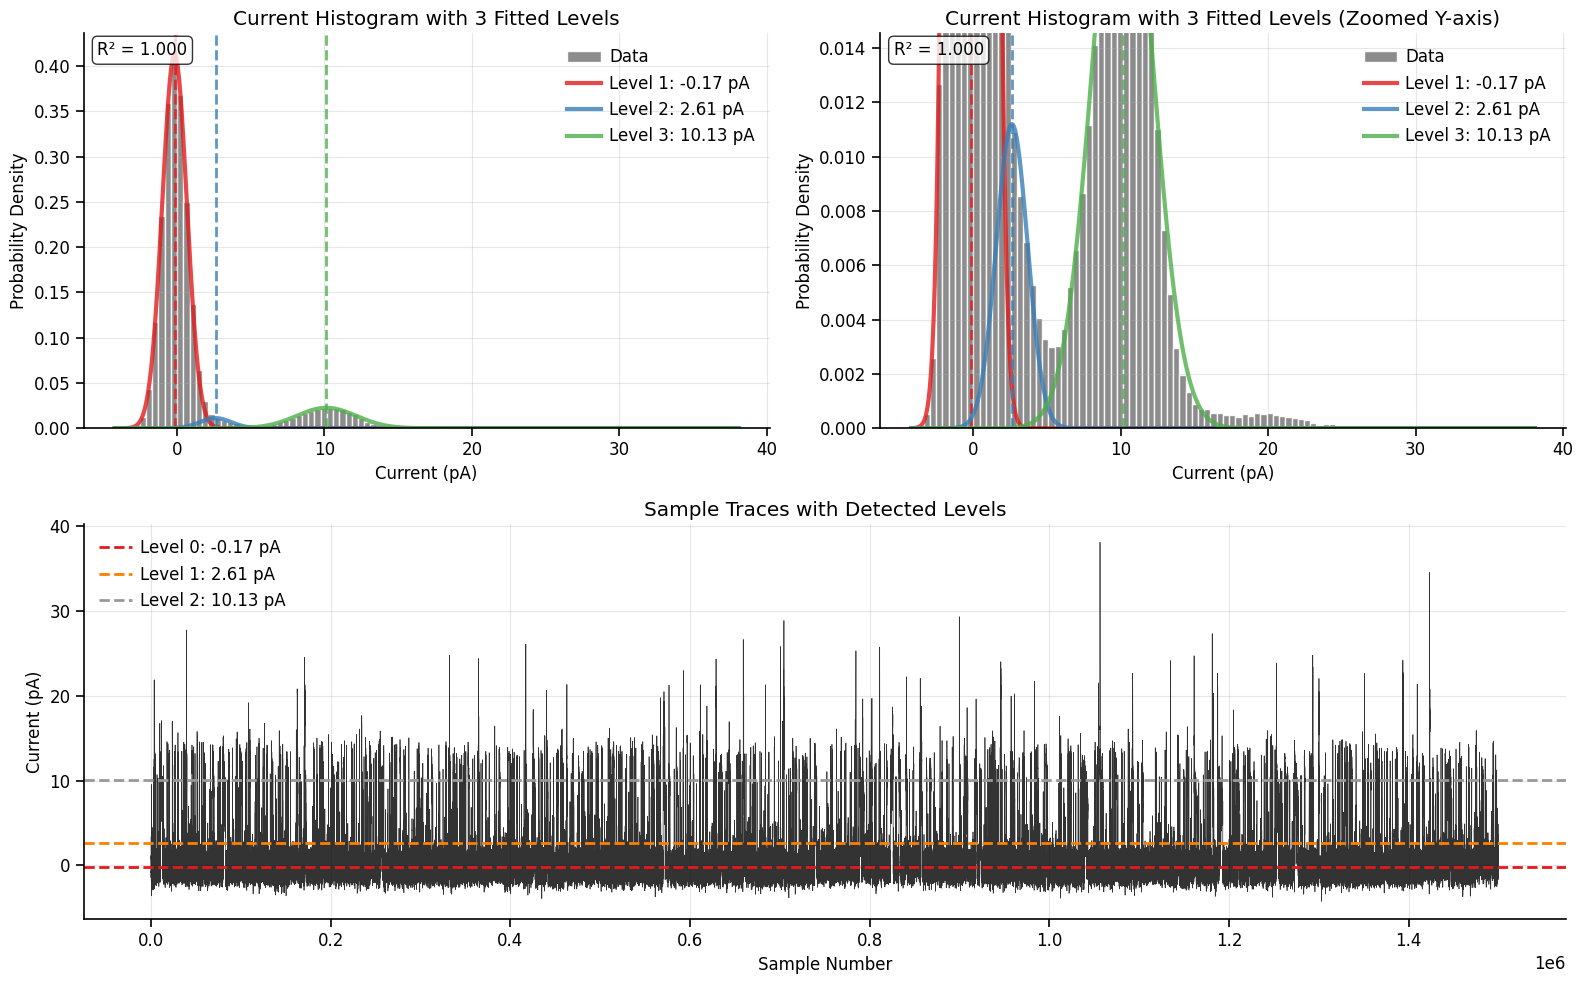


=== ITERATIVE LEVEL DETECTION RESULTS ===
Method: gaussian_subtraction (factor: 1.0)
Detected 3 current levels:
  Level 0: -0.173 pA
  Level 1: 2.613 pA
  Level 2: 10.127 pA


In [13]:
# Flip the trace (at the moment the idealization only works with positive levels)
if current_direction == 'inward':
    filtered_traces = -traces.current_data

# # Detect levels automatically by fitting Gaussian distributions to the histogram
detected_levels = detect_levels_from_histogram(filtered_traces, 
                                            n_levels=3,  # Specify number of levels (baseline + open levels)
                                            mean_guesses=[0,5,10],  # Initial guesses for means
                                            bins=100)

#### Enter the value (pA) of each level for the trace idealization.

**Note:** the automatic gaussian fit usually fails to detect the highest level correctly, so look at the trace closely to choose the value manually.

(it's probably a multiple of the previous level)


In [14]:
detected_levels = [-0.173, 10.127, 20.2]

# Initialize detector with your filtered traces
detector = MultiLevelEventDetector(filtered_traces, traces.time, traces.sampling_rate)

detector.set_current_levels(detected_levels)

Set 3 current levels:
  Baseline: -0.17 pA
  L1: 10.13 pA
  L2: 20.20 pA
Detection thresholds: ['4.98', '15.16'] pA


### 3.4. Detect channel open/close events and idealize single-channel behavior

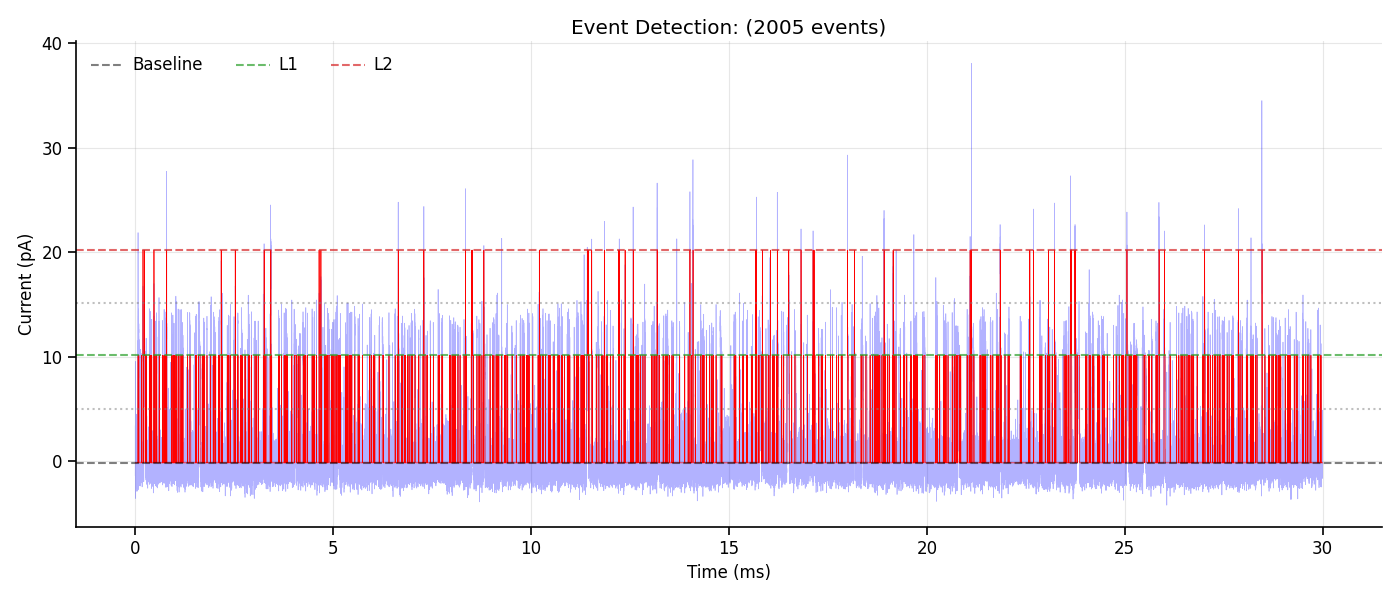

In [29]:
# Set detection parameters
detector.min_event_duration = 0.3  # ms - adjust based on your channel kinetics

%matplotlib widget
events, idealized_trace = detector.detect_events(plot_result=True)

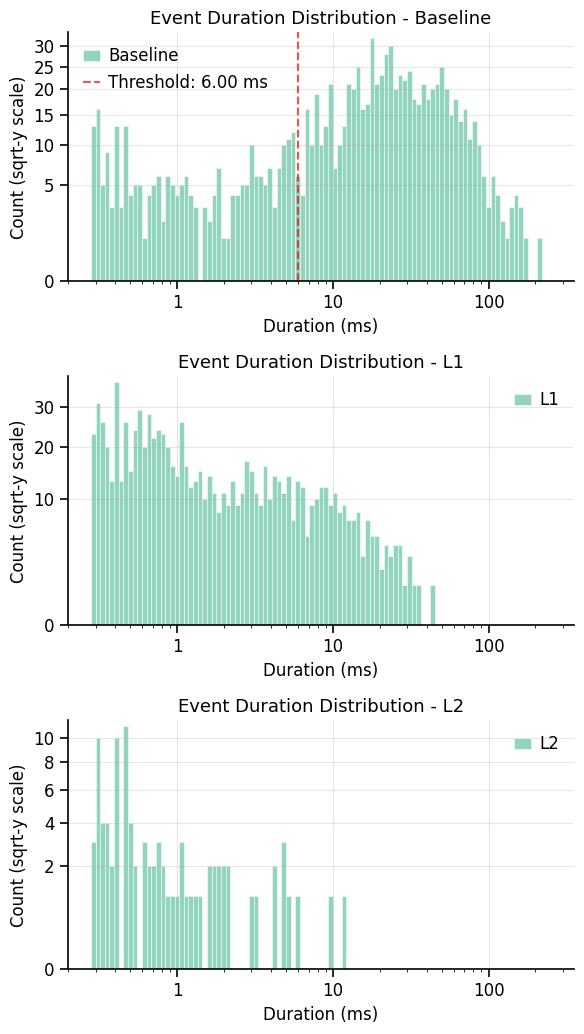

In [16]:
# Based on the histogram of closed durations, determine a threshold for burst separation
closed_threshold = 6  # ms - adjust based on your histogram

%matplotlib inline
durations = detector.plot_duration_histogram(bins=100, threshold=closed_threshold,
                                             fit_gaussian=True,
                                             log_x=True, sqrt_y_scale=True, separate_plots=True)

Burst Analysis (threshold: 6 ms)
Number of bursts: 546
Mean burst duration: 7.27 ms
Mean Po within bursts: 0.8113


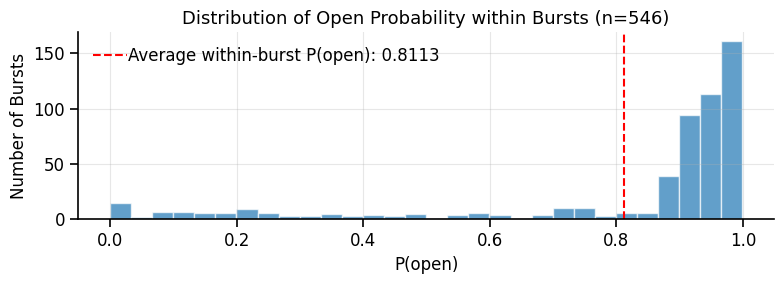

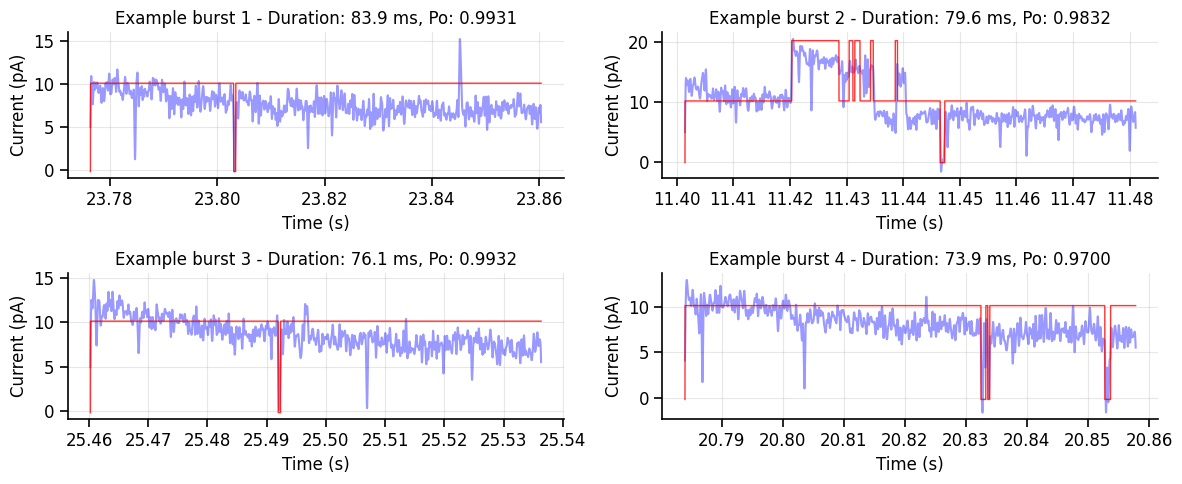

In [28]:
# Analyze the open probability within an activity burst
burst_data, burst_summary = detector.analyze_bursts(closed_threshold)

%matplotlib inline
detector.plot_burst_analysis(burst_data)

In [19]:
po_by_level, statistics = detector.calculate_level_probability(method='time_based')
detector.generate_analysis_report()

SINGLE-CHANNEL ANALYSIS REPORT

BASIC STATISTICS:
  Total events detected: 2005

CURRENT LEVELS:
  Baseline: -0.173 pA
  L1: 10.127 pA
  L2: 20.200 pA

LEVEL PROBABILITIES:
  Baseline: 0.8855 (88.550%)
  L1: 0.1104 (11.044%)
  L2: 0.0041 (0.405%)

RECORDING TIME:
  Total: 30.000 s
  Baseline: 26.565 s
  L1: 3.313 s
  L2: 0.122 s

EVENT DURATIONS:
  Baseline: 26.63 ± 29.35 ms (median: 17.88 ms, n=997)
  L1: 3.60 ± 5.48 ms (median: 1.14 ms, n=915)
  L2: 1.29 ± 1.87 ms (median: 0.50 ms, n=93)


## Calculate P(open) based on binomial distribution

If we have a good recording, we might be able to confidently say exactly how many channels are in our patch (from the largest open conductance level we see in the current trace). 

For example, there might be exactly 3 discrete conductance levels above baseline, consistent with 1, 2, or 3 BK channels being open. 

If we make a few assumptions, we can use the binomial theorem to calculate the P(open) for a single channel based on the amount of time spend in each conductance level. 

Assuming:
- All channels are identical,
- Each channel is **either open or closed** (no partial conductance states / sublevels)
- Channels behave **independently**
- The system is stationary / at steady state

We can model the number of open channels as a **binomial distribution**:

$$ P(k) = \binom{3}{k} p^k (1 - p)^{3 - k} = \frac{3!}{k!(3-k)!} p^k (1 - p)^{3 - k} $$

where:
- $P(k)$ is the probability of observing $k$ channels open
- $p$ is the open probability of a single channel
- $3$ is the total number of channels (maximum conductance level observed)

By plugging in different values for $k$ from 0 to 3, we get the expected occupancy of each conductance level:
- $ P(0) = (1 - p)^3 $
- $ P(1) = 3p(1 - p)^2 $
- $ P(2) = 3p^2(1 - p) $
- $ P(3) = p^3 $


Now we just need to fit our empirical data to these equations to estimate the single-channel open probability $p$.

We can set this up as a least-squares optimization problem (estimating $p$ by minimizing the squared error between the observed and expected probabilities, and finding the value of $p$ that minimizes the error):

$$ \text{error}(p) = \sum_{k=0}^{3} \left[ \hat{P}(k) - \binom{3}{k} p^k (1 - p)^{3 - k} \right]^2 $$

In [20]:
po_by_level

{'Baseline': 0.8855026666666667, 'L1': 0.110444, 'L2': 0.004053333333333333}

In [24]:
# Enter the total number of channels (based on max conductance level observed)
n = 2

P_obs = np.array([val for val in po_by_level.values()]) # Proportion of time spent in each state/level
p_estimate, residuals = estimate_p_open(P_obs, n)
print_p_open_results(p_estimate, residuals, P_obs, n)

SINGLE-CHANNEL P(OPEN) ESTIMATION
Number of channels: 2
** Estimated instantaneous P(open): 0.0588 **

FIT QUALITY:
------------------------------
State | Observed | Predicted | Residual
------------------------------
   0  |  0.8855  |   0.8858  |  -0.0003
   1  |  0.1104  |   0.1108  |  -0.0003
   2  |  0.0041  |   0.0035  |   0.0006
------------------------------
Residual sum of squares: 0.000001
Root mean square error:  0.000418

INTERPRETATION:
------------------------------
• P(open) is the instantaneous probability that any single channel is open
  at any given moment in time
• Residuals show how well the binomial model fits your data
  (Small residuals indicate good agreement)


## Fit a Hidden Markov Model to estimate the channel switching behavior